In [1]:
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import numpy as np
import numpy.matlib

In [16]:
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = ['Arial']
matplotlib.rcParams['font.sans-serif'] = ['System Font', 'Verdana', 'Arial']
matplotlib.rcParams['figure.figsize'] = (7, 3)   # Change the size of plots
matplotlib.rcParams['figure.dpi'] = 108

In [40]:
def proc(x, M, N):
    h_x0 = np.ones(x.shape) * np.nan
    h_u0 = np.ones(x.shape) * np.nan
    h_dx = np.ones(x.shape) * np.nan
    y = np.ones(x.shape) * np.nan
    b = 1.0 / M
    a = 1.0 - b

    u0 = 0
    x0 = 0
    for i in range(2, len(x)):
        if i < N:
            if i % 2 == 0:
                x0 = np.mean(x[:i])
                u0 = np.mean(u[:i])
            dx = (x[i] - x[0]) / (u[i] - u[0])
        else:
            if i % 2 == 0:
                x0 = np.mean(x[i - N : i])
                u0 = np.mean(u[i - N : i])
            dx = a * dx + b * (x[i] - x[i - N]) / (u[i] - u[i - N])

        y[i] = x0 + dx * (u[i] - u0)
        # Keep a history
        h_x0[i] = x0
        h_u0[i] = u0
        h_dx[i] = dx

    # For plotting, set the beginning t values to be nice
    y[1] = y[2] - (y[4] - y[3])
    y[0] = y[1] - (y[3] - y[2])
    
    return y, h_x0, h_u0, h_dx

In [41]:
def showChart(y, h_x0, h_u0, h_dx):
    fig = matplotlib.pyplot.figure(figsize=(11, 6))

    tt = t - t[0]

    ax1 = fig.add_subplot(221)
    h1 = ax1.plot(tt, 1.0e3 * (y - t), '-g')
    ax1.grid()
    ax1.text(t[-1] - t[0], 1.3, 'M = {}, N = {}'.format(M, N), ha='right')
    matplotlib.pyplot.ylabel('Time Error (ms)')
    matplotlib.pyplot.ylim([-3.0, 3.0])

    ax2 = fig.add_subplot(222)
    ax2.plot(tt, h_dx * tics_per_second, label='Estimate')
    ax2.plot(tt[[0, -1]], np.array([1.0, 1.0]), '--', label='True dx / du')
    ax2.grid()
    ax2.legend()
    matplotlib.pyplot.ylim([0.999, 1.001])
    matplotlib.pyplot.title('Time History of dx / du')

    ax3 = fig.add_subplot(223)
    h31 = ax3.plot(tt, (h_u0 - h_u0[-1] + u[-1]) / tics_per_second)
    h32 = ax3.plot(tt[[0, -1]], (u[[0, -1]]) / tics_per_second, '--')
    ax3.grid()
    ax3.legend(h31 + h32, ['Estimate', 'True u0 (slope)'])

    ax4 = fig.add_subplot(224)
    h41 = ax4.plot(tt, h_x0 - h_x0[-1] + tt[-1])
    h42 = ax4.plot(tt[[0, -1]], tt[[0, -1]], '--')
    ax4.grid()
    ax4.legend(h41 + h42, ['Estimate', 'True x0 (slope)'])

    return fig

In [42]:
# Unit time
d = 1.0 / 2000.0

# Time-series data usually come in chunks
chunk_size = 8

# A scaling constant of the clean reference
tics_per_second = 1000000

# Have the time-series to be at least X seconds
K = int(10.0 / d / chunk_size / 2) * chunk_size * 2

# Emulate staggered PRT: 2, 3, 2, 3, ... (ms)
s = np.cumsum(np.kron(np.ones(int(K / 2), ), [2, 3])) * d

# Emulate uniform PRT: 1, 1, 1, ... (ms)
# s = np.cumsum(np.ones(K, )) * d

# Clean reference of tic count
u_orig = 19760520
u = (s + u_orig) * tics_per_second

# Time in double with an arbitrary offset
t_orig = 7000.0
t = s + t_orig

# Add noise to x, on the orders of milliseconds
L = round(K / chunk_size, )
jitter = np.kron(1.0e-3 * (np.random.random(L, ) - 0.5), np.ones(chunk_size, ))
burst = np.kron(np.ones(L, ), np.linspace(0, 0.02e-3, chunk_size) - 0.01e-3)

x_orig = t_orig
x = t + jitter + burst

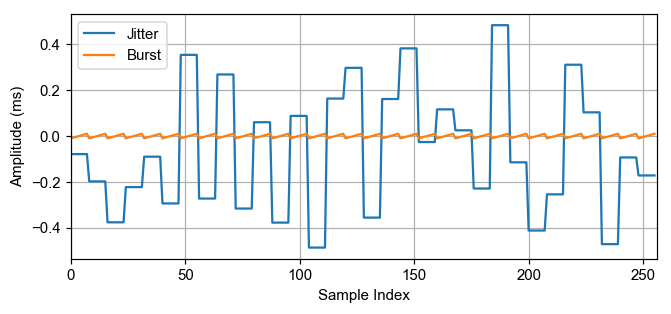

In [43]:
L = 256
matplotlib.pyplot.plot(1.0e3 * jitter[:L], label='Jitter')
matplotlib.pyplot.plot(1.0e3 * burst[:L], label='Burst')
matplotlib.pyplot.xlim([0, L])
matplotlib.pyplot.legend()
matplotlib.pyplot.grid()
matplotlib.pyplot.xlabel('Sample Index')
matplotlib.pyplot.ylabel('Amplitude (ms)')

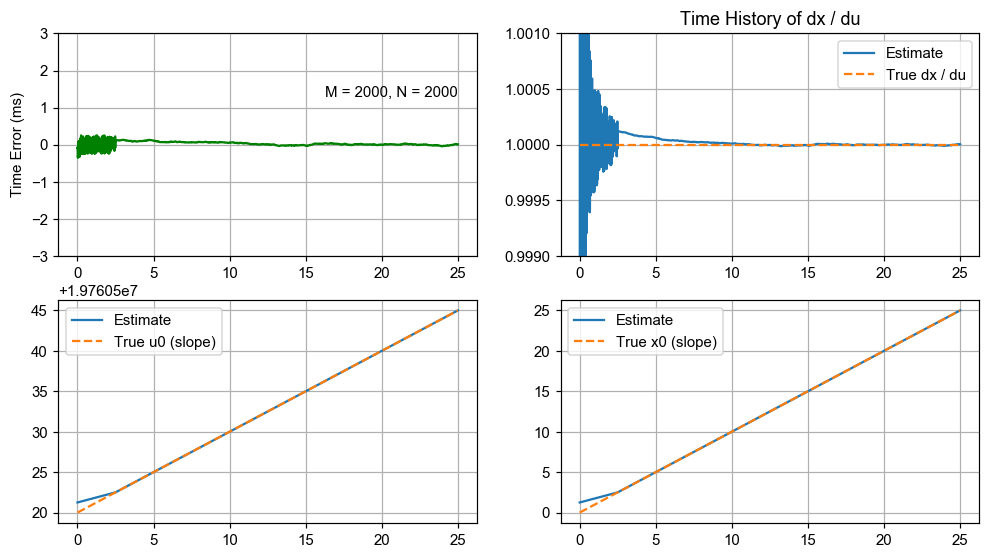

In [44]:
# Stride size of the running window
M = 2000
N = 2000

# for M in [1000, 2000, 5000, 10000]:
y, h_x0, h_u0, h_dx = proc(x, M, N)
fig = showChart(y, h_x0, h_u0, h_dx)
# fig.savefig(os.environ['HOME'] + '/Desktop/m{0:02.0f}-n{1:02.0f}.png'.format(M / 1000, N / 1000))

Original jitter = 0.139046100639  ms
Smoothed jitter = 0.00163040836104  ms


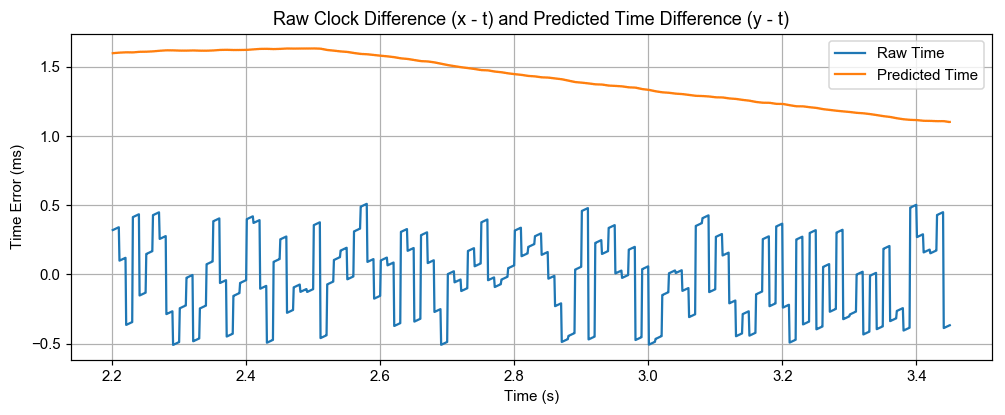

In [39]:
O = int(2.2 / ((2 + 3) * d) * 2)
L = 1000

ts1 = 1.0e3 * (x[O : O + L] - t[O : O + L])
ts2 = 1.0e3 * (y[O : O + L] - t[O : O + L])

print('Original jitter =', np.std(np.diff(ts1)), ' ms')
print('Smoothed jitter =', np.std(np.diff(ts2)), ' ms')

tt = t[O : O + L] - t_orig

fig = matplotlib.pyplot.figure(figsize=(11, 4))
matplotlib.pyplot.plot(tt, ts1, label='Raw Time')
matplotlib.pyplot.plot(tt, ts2, label='Predicted Time')
matplotlib.pyplot.grid()
matplotlib.pyplot.legend()
matplotlib.pyplot.xlabel('Time (s)')
matplotlib.pyplot.ylabel('Time Error (ms)')
matplotlib.pyplot.title('Raw Clock Difference (x - t) and Predicted Time Difference (y - t)')

In [ ]:
matplotlib.pyplot.plot(np.diff(t[-50:]))
matplotlib.pyplot.plot(np.diff(y[-50:]))
matplotlib.pyplot.grid()
matplotlib.pyplot.ylim([0.25 * d, 4.0 * d])